# **Знакомство с данными, обработка пропусков и выбросов**

Какие данные нам предоставили, чтобы мы могли выявить решающие факторы для успеха маркетинговой кампании? В целом их можно разделить на несколько групп.

**Данные о клиентах банка:**

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**

* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

**Прочие признаки:**

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).
* ***deposit*** наша целевая переменная, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

Начнём с того, что оценим, насколько предложенные данные готовы к дальнейшему анализу. В первую очередь давайте выясним, есть ли в данных пропущенные значения (пустые, незаполненные ячейки).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

### **Задание 2.1**

В каком признаке пропущенных значений больше всего?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Вы успешно справились с предыдущим заданием и выяснили количество пропущенных значений. Однако в настоящих данных обычно всё не так просто, и пропущенные (неизвестные) значения могут присутствовать неявным образом. Это значит, что они могут быть закодированы каким-то словом или набором символов. Часто это не является проблемой, но это необходимо выявить. В наших данных именно такая ситуация (например, в признаке со сферой занятости). Узнайте, каким именно словом закодированы пропущенные (неизвестные) значения.

### **Задание 2.2**

Введите слово, которым закодированы пропуски (неизвестные значения).

In [4]:
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

Мы нашли пропущенные значения, и хотелось бы теперь их обработать. Однако мы не можем этого сделать, так как не все данные представлены в корректном виде.

Обратите внимание на признак balance: в данных содержится лишняя запятая и знак доллара. По этой причине этот признак не считывается как число. Обработайте данные этого признака так, чтобы он был преобразован в тип float.

### **Задание 2.3**

Вычислите среднее значение по преобразованному в корректный вид признаку balance. Ответ округлите до трёх знаков после точки-разделителя.

In [5]:
def make_convert(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan

df['balance'] = df['balance'].apply(make_convert)

df['balance'].mean().round(3)

1529.129

Итак, значения в признаке balance приобрели нормальный вид, и теперь мы можем обработать пропуски, которые в нём присутствуют. Конечно, пропуски можно было бы просто удалить, но мы поступим по-другому: заменим пропуски на медианное значение по этому признаку.

### **Задание 2.4**

Вычислите среднее значение по преобразованному в корректный вид признаку balance. Ответ округлите до трёх знаков после точки-разделителя.

In [6]:
median_balance = df['balance'].median()
df['balance'].fillna(median_balance, inplace=True)
df['balance'].mean().round(3)

1526.936

Ранее мы выяснили, что в признаке job есть пропущенные значения, которые не отображаются как пропуски в явном виде. Однако нам всё равно важно их обработать. Мы знаем, что для категориальных признаков пропущенные значения заменяются модой по данному признаку.

Замените все пропущенные значения в признаке job на модальные. То же самое сделайте с признаком, отвечающим за уровень образования.

### **Задание 2.5**

После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлите до трёх знаков после точки-разделителя.

In [7]:
mode_job = df['job'].mode()[0]
mode_education = df['education'].mode()[0]
df['job'] = df['job'].replace('unknown', mode_job)
df['education'] = df['education'].replace('unknown', mode_education)

df[(df['education']==mode_education) & (df['job']==mode_job)]['balance'].mean().round(3)

1598.883

Изучите признак, отображающий баланс клиентов, на предмет выбросов.

В математической статистике есть несколько подходов, позволяющих определить наличие выбросов. Мы будем считать, что выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычли полтора межквартильных размаха (Q1 - 1.5 * IQR) , а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха. (Q3 - 1.5 * IQR). Найдите эти границы, и отфильтруйте значения так, чтобы выбросов в данных не осталось.

*Примечание. Несмотря на то что существуют более продвинутые методы поиска аномальных значений, для обработки одного числового признака достаточно хорошо подходит метод Тьюки. После решения задачи вы сможете попробовать применить и другие методы, оценив их влияние на качество поиска.*

### **Задание 2.6**

Введите верхнюю и нижнюю границы поиска выбросов по методу Тьюки, округлив их до целых чисел.

In [8]:
df_copy = df.copy()

In [9]:
df['balance'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 11162 entries, 0 to 11161
Series name: balance
Non-Null Count  Dtype  
--------------  -----  
11162 non-null  float64
dtypes: float64(1)
memory usage: 87.3 KB


In [10]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bound, upper_bound = outliers_iqr(df_copy, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(f'Нижняя граница по Тьюки: {lower_bound}')
print(f'Верхняя граница по Тьюки: {upper_bound}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Нижняя граница по Тьюки: -2241.0
Верхняя граница по Тьюки: 4063.0


***
# **Разведывательный анализ данных**

✍ В данной части проекта вам необходимо будет:

* исследовать данные;
* попробовать найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими для оформления депозита;
* дополнить ваш анализ визуализациями, иллюстрирующими ваше исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.

Давайте изучим распределение целевой переменной: есть ли несбалансированность классов? Чтобы это определить, вычислите частоты для открывших депозит и для тех, кто его не открыл. Сопроводите числа диаграммой, отражающей полученные результаты.

### **Задание 3.1**

Сколько клиентов открыли депозит?

no     5424
yes    4681
Name: deposit, dtype: int64

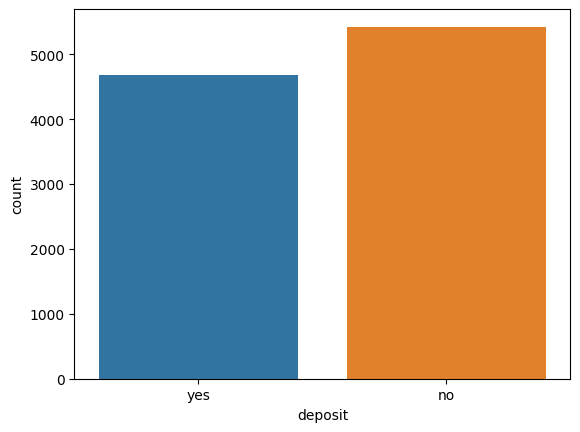

In [11]:
sns.countplot(data=cleaned, x='deposit');
cleaned['deposit'].value_counts()

Начнём с описательных статистик для количественных переменных.

* Рассчитайте их и продумайте подробную интерпретацию.
* Попробуйте описать данные, которые у вас есть, увидеть первые зависимости.
* Рассмотрите минимальные и максимальные значения.
* Посмотрите на меры разброса и оцените, насколько данные вариативны.
* Сравнив меры центральной тенденции, сделайте выводы о том, есть ли аномальные значения с меньшей или большей стороны.
* Дополните выводы визуализациями. Вспомните, какие диаграммы могут помочь в иллюстрации распределений количественных данных.

count    10105.000000
mean        40.895497
std         11.734931
min         18.000000
25%         32.000000
50%         38.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

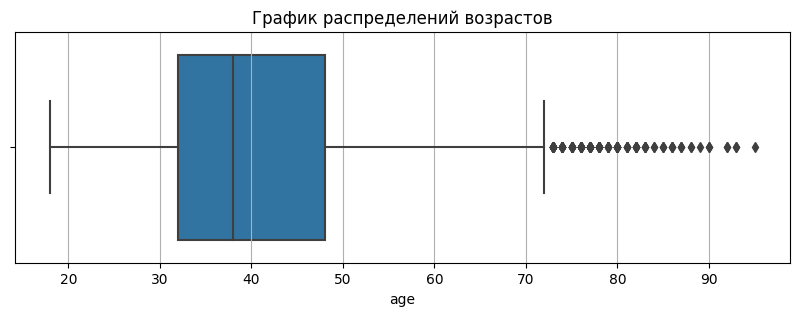

In [12]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 3))
ax1.set_title('График распределений возрастов')
plt.grid()
sns.boxplot(cleaned['age'], ax=ax1);
# описательные статистики
display(cleaned['age'].describe())

### **Задание 3.2**

Каков максимальный возраст клиента банка?

In [13]:
cleaned['age'].max()

95

### **Задание 3.3**

Какова минимальная продолжительность разговора с клиентом банка? Ответ дайте в количестве секунд.

In [14]:
cleaned['duration'].min()

2

Теперь давайте рассмотрим описательные статистики для категориальных переменных.

Попробуйте извлечь максимум информации из тех показателей, которые можете получить. Сколько всего сфер занятости представлено среди клиентов банка? В каждый ли месяц проходила маркетинговая кампания? Какое семейное положение встречается чаще всего? А образование? Постарайтесь дать достаточно подробную интерпретацию. Для лучшей наглядности добавьте визуализации по каждой категориальной переменной.

    Совет. Вопросы, приведённые выше, — это лишь пример того, что можно рассмотреть. Постарайтесь самостоятельно составить различные выводы и описать их. Сделайте информативные и красивые визуализации, дополняющие ваши выводы.

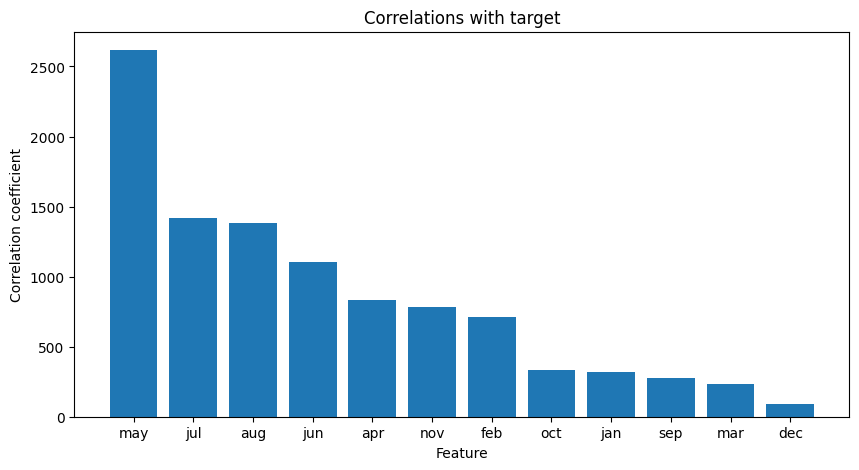

In [24]:
# Сколько всего сфер занятости представлено среди клиентов банка?
cleaned['job'].describe()
# В каждый ли месяц проходила маркетинговая кампания?
cleaned['month'].unique()
# Какое семейное положение встречается чаще всего?
cleaned['marital'].describe()
# Какое образование встречается чаще всего?
cleaned['education'].describe()

# подробная интерпретация
plot_data = pd.DataFrame(cleaned['month'].value_counts())
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5)) #фигура+координатная плоскость
ax.bar(plot_data.index.tolist(), [item for sublist in plot_data.values.tolist() for item in sublist]) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y

### **Задание 3.4**

Сколько было месяцев, в которых проводилась маркетинговая кампания?

In [26]:
12

12

### **Задание 3.5**

Сколько сфер занятости представлено среди клиентов банка?

In [27]:
# Сколько всего сфер занятости представлено среди клиентов банка?
cleaned['job'].describe()

count          10105
unique            11
top       management
freq            2315
Name: job, dtype: object

Теперь давайте узнаем, есть ли разница в результатах текущей маркетинговой кампании и предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная. Узнайте, **для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач**.

### **Задание 3.6**

Напишите значение статуса предыдущей кампании, для которой в текущей успехов намного больше, чем неудач.

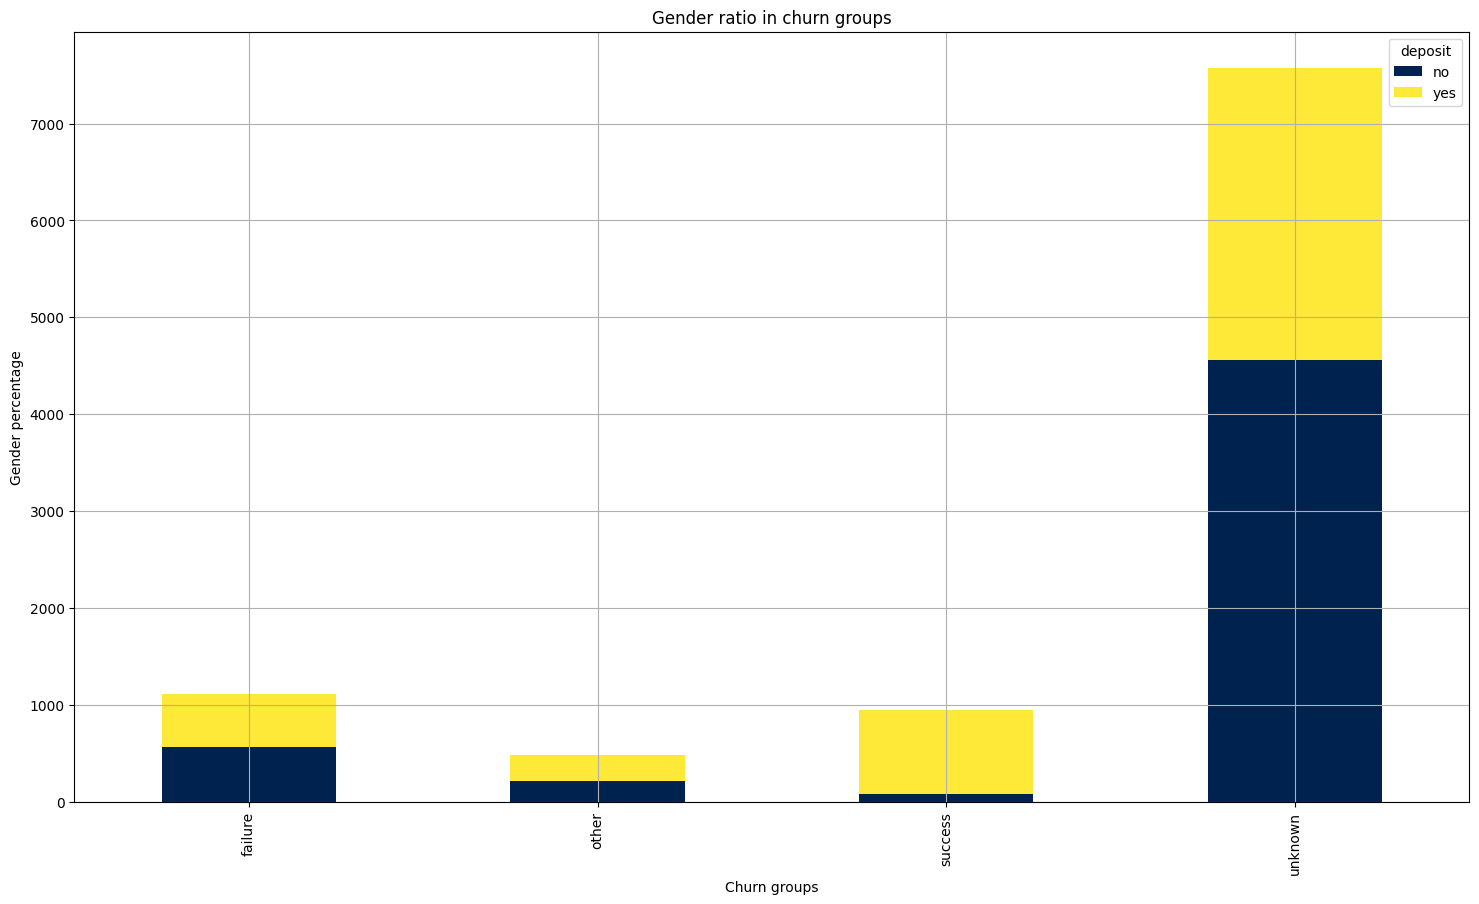

In [64]:
bar_data = cleaned.groupby(['poutcome'])['deposit'].value_counts().unstack(level=1)
bar_data.plot(
    kind='bar',
    stacked=True,
    figsize=(18, 10),
    xlabel='Churn groups',
    ylabel='Gender percentage',
    #yticks=bar_data['Female'],
    colormap='cividis',
    grid=True,
    title='Gender ratio in churn groups'
);

Теперь давайте узнаем, какова зависимость результата маркетинговых кампаний от месяца.

Временные периоды, сезоны, близость к каким-то праздникам часто влияют на решение клиентов использовать определённые услуги.

### **Задание 3.7**

Рассчитайте, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании. Возможно, этот месяц не является подходящим для проведения подобных акций, и это стоит отметить. Введите название месяца латиницей ровно так, как месяц обозначен в данных.

In [127]:
bar_data = cleaned.groupby(['month'])['deposit'].value_counts().sort_index()
list_of_percent = {}
sum = 0
for i in range(0,bar_data.shape[0],2):
    sum = bar_data[i]+bar_data[i+1]
    percentage = bar_data[i]/sum
    list_of_percent[bar_data.index[i]]=percentage
list_of_percent =pd.DataFrame(list_of_percent.items(), columns=['Month', 'Failure percentage'])
list_of_percent.sort_values(by='Failure percentage', ascending=False)

,Month,Failure percentage
8,"(may, no)",0.678640
4,"(jan, no)",0.608150
5,"(jul, no)",0.589563
9,"(nov, no)",0.584615
1,"(aug, no)",0.559567
6,"(jun, no)",0.548913
3,"(feb, no)",0.455571
0,"(apr, no)",0.381928
10,"(oct, no)",0.185075
11,"(sep, no)",0.165468
